In [1]:
from constants import FLUXES_FOLDER, SLM_FOLDER

from data_utils import process_amp_phase_data,\
                       add_row_padding

from plot_utils import plot_autoencoder, \
                       plot_model_history

from modeling_utils import create_autoencoder_for_flux, \
                           compile_model, \
                           train_model

from configurations import AutoEncoderConfiguration as ModelConfig

2023-12-01 14:32:05.559432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 14:32:06.170413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
fluxes_filename = "all_fluxes.npy"
amplitudes_filename = "complexsine_pupamp.npy"
phases_filename = "complexsine_pupphase.npy"

fluxes_path = f"{FLUXES_FOLDER}/{fluxes_filename}"
amplitudes_path = f"{SLM_FOLDER}/{amplitudes_filename}"
phases_path = f"{SLM_FOLDER}/{phases_filename}"

In [3]:
train_fluxes_array, val_fluxes_array, train_amp_phase_array, val_amp_phase_array, scalers = \
    process_amp_phase_data(
        fluxes_path, 
        amplitudes_path,
        phases_path,
        n_points=10000,
        trim_amplitude=True,
        trim_phase=True,
        normalize_flux=True,
        normalize_amplitude=True,
        shuffle=False,
        flatten_fluxes=False,
        split=True,
        val_ratio=0.1
    )

In [4]:
train_fluxes_array = add_row_padding(train_fluxes_array, 1)
val_fluxes_array = add_row_padding(val_fluxes_array, 1)

In [5]:
model_configuration = ModelConfig(train_fluxes_array)
print(model_configuration.get_description())


	=== FluxAutoencoder ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Autoencoder
		-Input shape: (56, 24)
		-Convolutional Layers: [256, 128, 16, 4] (Inverse in the decoder)
		-Convolutonal Kernels: [(3, 3), (3, 3), (3, 3), (3, 3)] (Inverse in the decoder)
		-Convolutional Activation: relu
		-Output Layer Activation: linear
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 50
		-Batch size: 16
		-Callbacks:
			-ReduceLROnPlateau: MSE 8 x0.1
			-Early Stop: MSE 15
	


2023-12-01 14:32:10.375852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 14:32:10.405475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 14:32:10.405750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
model = create_autoencoder_for_flux(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FluxAutoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 24, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 256)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 6, 128)        0         
 g2D)                                              

In [7]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [8]:
history = train_model(
    model,
    train_fluxes_array,
    train_fluxes_array,
    val_fluxes_array,
    val_fluxes_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/50


2023-12-01 14:32:13.932581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-01 14:32:14.723512: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-01 14:32:14.723557: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-01 14:32:15.541863: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f90ecbec900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 14:32:15.541901: I tensorflow/compiler/xla/service/service.cc:176]   Str

561/563 [============================>.] - ETA: 0s - loss: 0.2378 - mean_squared_error: 0.2378

2023-12-01 14:32:39.295727: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


563/563 [==============================] - 30s 39ms/step - loss: 0.2374 - mean_squared_error: 0.2374 - val_loss: 0.1055 - val_mean_squared_error: 0.1055 - lr: 1.0000e-04
Epoch 2/50
563/563 [==============================] - 19s 35ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - lr: 1.0000e-04
Epoch 3/50
563/563 [==============================] - 19s 35ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - lr: 1.0000e-04
Epoch 4/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - lr: 1.0000e-04
Epoch 5/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - lr: 1.0000e-04
Epoch 6/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0264 - mean_squared_error: 0

563/563 [==============================] - 20s 35ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - lr: 1.0000e-04
Epoch 47/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - lr: 1.0000e-04
Epoch 48/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - lr: 1.0000e-04
Epoch 49/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - lr: 1.0000e-04
Epoch 50/50
563/563 [==============================] - 20s 35ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - lr: 1.0000e-04


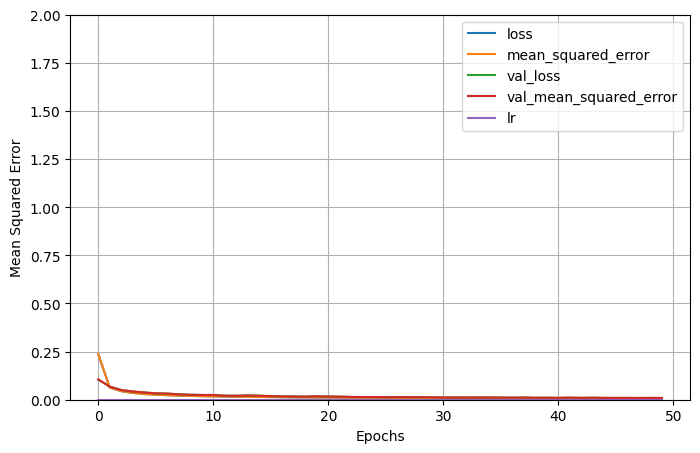

In [9]:
plot_model_history(history)

In [14]:
plot_autoencoder(model, val_fluxes_array[757])

1/1 [==============================] - 0s 18ms/step


In [16]:
plot_autoencoder(model, val_fluxes_array[758])

1/1 [==============================] - 0s 17ms/step
